# Práctica 2: Modelo cinemático inverso de un  y planteamiento de trayectoria

## Objetivo

El objetivo de esta práctica es que el alumno comprenda, interprete y modifique la información básica de los formatos de Universal Robot Description File (URDF).


### Metas 

- Que el alumno aplique un modelo cinemático inverso para calcular una trayectoria a partir de una posición actual hacia una posición final
- Que el alumno grafique y analice los resultados del modelo
- Que el alumno configure un repositorio en línea e incluya en éste su práctica

### Contribución al perfil del egresado

La siguiente práctica contribuye en los siguientes puntos al perfil del egresado:

#### Aptitudes y habilidades

- Para modelar, simular e interpretar el comportamiento de los sistemas mecatrónicos.
- Para diseñar, construir, operar y mantener los sistemas mecatrónicos y sus componentes.

#### Actitudes

- Tener confianza en su preparación académica.
- Comprometido con su actualización, superación y competencia profesional.

#### De tipo social

- Promover el cambio en la mentalidad frente a la competitividad internacional.

## Rúbrica de evaluación

La evaluación de la práctica contará de los siguientes puntos y se evaluará con los siguientes criterios:

| Elemento | Porcentaje |
| ------:| ----------- |
| **Cuestionario previo** | 15% | 
| **Desarrollo** | 35% |
| **Análisis de resultados**  | 35% |
| **Conclusiones** | 15% |

| Elemento | Malo | Regular | Bueno |
| ------:| ------ | --------| ------|
| **Cuestionario previo** | El trabajo no contiene cuestionario previo o todas las preguntas son incorrectas (0%)| Al menos la mitad de las preguntas son correctas (8%) |  Todas las preguntas son correctas (15%) |
| **Desarrollo** | El trabajo no contiene desarrollo o su planteamiento no concuerda con lo deseado (0%) | El desarrollo está mal planteado o no llega a los resultados esperados (10%) | El desarrollo tiene un planteamiento adecuado y llega a los resultados esperados (35%) |
| **Análisis de resultados**  | El trabajo no contiene análisis de resultados o la información no se está interpretando correctamente (0%) | La interpretación de los resultados es parcial o desorganizada (10%) | Realiza un correcto análisis de los resultados de forma organizada   (35%) |
| **Conclusiones** | El trabajo no contiene conclusiones o no hacen referencia al trabajo desarrollado y los objetivos planteados (0%) | La redacción de las conclusiones es desorganizada o confusa (8%) | Las conclusiones del trabajo son claras y hacen referencia al trabajo desarrollado y los objetivos planteados (15%) | 



## Introducción

### Transformaciones homogéneas
Las transformaciones homogéneas permiten hacer el planteamiento del modelo cinemático de un robot, considerando las posiciones y orientaciones de las juntas del robot respecto al sistema de referencia de una junta anterior

Este planteamiento es el **modelo de cinemática directa**, que nos permite obtener la posición y velocidad del efector final de un manipulador en términos de los valores de la posición y velocidad de sus juntas (espacio de trabajo)

A través de este modelo se puede obtener el **modelo de cinemática inversa**, que permite obtener la velocidad de las juntas de un robot a partir de la velocidad deseada del efector final.

### Planteamiento de una trayectoria
Si se conoce el punto inicial y final de una trayectoria deseada, se pueden obtener los puntos intermedios de la trayectoria. La forma más fácil de realizar esta interpolación es a través de un spline. El orden del spline permitirá controlar las condiciones inicial y final de la posición, velocidad ó aceleración que tendrá el efector final durante el trayecto. 

Juntando la interpolación de la trayectoria y el modelo de la cinemática inversa, se pueden obtener todos los puntos intermedios de la trayectoria que deben seguir las juntas del robot para que el efector final siga una trayectoria.

## Cuestionario previo

Responder de forma breve las siguientes preguntas:

- ¿Que son las transformaciones homogéneas?

  
  Son herramientas matemáticas que describen la relación entre sistemas de coordenadas. Las transformaciones homogéneas permiten hacer el planteamiento del modelo cinemático de     un robot, considerando las posiciones y orientaciones de las juntas del robot respecto al sistema de referencia de una junta anterior
  
- ¿Que nos permite obtener el modelo de cinemática inversa de un manipulador?

  
  La velocidad de las juntas de un robot a partir de la velocidad deseada del efector final.
  
- ¿De que formas se puede interpolar la trayectoria de un efector final entre dos puntos?

  
  A través de un spline. El orden del spline permitirá controlar las condiciones inicial y final de la posición, velocidad ó aceleración que tendrá el efector final durante el      trayecto.
  
- ¿Qué es git?

  
  Git es un sistema de control de versiones distribuido que permite a los desarrolladores rastrear y administrar cambios en el código fuente a lo largo del tiempo. Facilita la      colaboración entre varios desarrolladores al permitir que cada uno trabaje en una copia independiente del proyecto, integrando los cambios posteriormente.
  
- ¿Qué es github?

  
  GitHub es una plataforma basada en la web que utiliza Git como sistema de control de versiones. Ofrece herramientas adicionales para la colaboración, como seguimiento de          problemas, revisiones de código y alojamiento de repositorios públicos o privados. También actúa como una red social para desarrolladores, permitiéndoles compartir proyectos y    contribuir a repositorios abiertos.


## Desarrollo

### 1. Planteamiento de la cinemática directa
En esta primera parte, se crearán las transformaciones homogéneas y el modelo de cinemática directa de un robot RRR, incluyendo la matriz del Jacobiano. Se recomienda usar **Sympy** para el planteamiento de las expresiones. 
Un diagrama del robot se muestra en la imagen:

<img src="imagenes/P2_IM1.png" alt = "Robot RRR" width="300" height="300" display= "block"/>



In [1]:
#!/usr/bin/env python3
import rclpy
from rclpy.node import Node
from std_msgs.msg import String
from sensor_msgs.msg import JointState
from sympy import *
from sympy import solve, Symbol, Matrix, cos, sin, simplify, pi, diff, symbols
import matplotlib
import matplotlib.pyplot as plt
import numpy

dim = (0.3, 0.3, 0.3)
base_dim = (0, 0, 0.1)
base_rot = (pi/2, 0, 0)


def trans_homo(x, y, z, gamma, beta, alpha):
    T = Matrix([[cos(alpha)*cos(beta), -sin(alpha)*cos(gamma)+sin(beta)*sin(gamma)*cos(alpha), sin(alpha)*sin(gamma)+sin(beta)*cos(alpha)*cos(gamma), x],
         [sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-sin(gamma)*cos(alpha), y],
        [-sin(beta), sin(gamma)*cos(beta), cos(beta)*cos(gamma), z],[0, 0, 0, 1]])
    return T 

#Parámetros de dimensiones
dim = dim
base_dim = base_dim
base_rot = base_rot
#Variables para cinemática directa
theta_O_1 = Symbol('theta_O_1')
theta_1_2 = Symbol('theta_1_2')
theta_2_3 = Symbol('theta_2_3')
#Grados de libertad
x_O_P = Symbol('x_O_P')
z_O_P = Symbol('y_O_P')
theta_O_P = Symbol('theta_O_P')
#Velocidades
x_O_P_dot = Symbol('x_O_P_dot')
z_O_P_dot = Symbol('y_O_P_dot')
theta_O_P_dot = Symbol('theta_O_P_dot')
#Transformaciones homogéneas
T_O_O = trans_homo(base_dim[0], base_dim[1], base_dim[2], 
                        base_rot[0], base_rot[1], base_rot[2])
T_O_1 = trans_homo(0, 0, 0, 
                        0, 0, theta_O_1)
T_1_2 = trans_homo(dim[0], 0, 0, 
                        0, 0, theta_1_2)
T_2_3 = trans_homo(dim[1], 0, 0, 
                        0, 0, theta_2_3)
T_3_P = trans_homo(dim[2], 0, 0, 
                        0, 0, 0)
T_O_P = simplify(T_O_O * T_O_1 * T_1_2 * T_2_3 * T_3_P)
print("GDL del robot")
print(T_O_P[0,3])
print(T_O_P[1,3])
print(T_O_P[2,3])
print(T_1_2)
print(T_O_P)
xi_O_P = Matrix([T_O_P[0, 3], T_O_P[2, 3], 
                      theta_O_1 + theta_1_2 + theta_2_3])
J = Matrix.hstack(diff(xi_O_P, theta_O_1), 
                       diff(xi_O_P, theta_1_2), 
                       diff(xi_O_P, theta_2_3))
J_inv = J.inv()
print(J)



/home/francojasso/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


GDL del robot
0.3*cos(theta_O_1) + 0.3*cos(theta_1_2 + theta_O_1) + 0.3*cos(theta_1_2 + theta_2_3 + theta_O_1)
0
0.3*sin(theta_O_1) + 0.3*sin(theta_1_2 + theta_O_1) + 0.3*sin(theta_1_2 + theta_2_3 + theta_O_1) + 0.1
Matrix([[cos(theta_1_2), -sin(theta_1_2), 0, 0.300000000000000], [sin(theta_1_2), cos(theta_1_2), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
Matrix([[cos(theta_1_2 + theta_2_3 + theta_O_1), -sin(theta_1_2 + theta_2_3 + theta_O_1), 0, 0.3*cos(theta_O_1) + 0.3*cos(theta_1_2 + theta_O_1) + 0.3*cos(theta_1_2 + theta_2_3 + theta_O_1)], [0, 0, -1, 0], [sin(theta_1_2 + theta_2_3 + theta_O_1), cos(theta_1_2 + theta_2_3 + theta_O_1), 0, 0.3*sin(theta_O_1) + 0.3*sin(theta_1_2 + theta_O_1) + 0.3*sin(theta_1_2 + theta_2_3 + theta_O_1) + 0.1], [0, 0, 0, 1]])
Matrix([[-0.3*sin(theta_O_1) - 0.3*sin(theta_1_2 + theta_O_1) - 0.3*sin(theta_1_2 + theta_2_3 + theta_O_1), -0.3*sin(theta_1_2 + theta_O_1) - 0.3*sin(theta_1_2 + theta_2_3 + theta_O_1), -0.3*sin(theta_1_2 + theta_2_3 + theta_O_1)], [0.3*co

### 2. Cinemática inversa
A partir del modelo de la cinemática directa, obtener la expresión e la cinemática inversa, que relacione las velocidades de las juntas del robot con la velocidad del efector final. Ya que el modelo de cinemática inversa sólo permite obtener velocidades, obtener también expresiones que permitan obtener la posición de las juntas y sus aceleraciones

In [5]:
frec = 30
time = (0, 3)
gdl_in = (0.8, 0.1, 0)
gdl_fn = (0.4, 0.4, 0)

frec = frec
a_0, a_1, a_2, a_3, a_4, a_5, t = symbols('a_0 a_1 a_2 a_3 a_4 a_5 t')
lam = a_0 + a_1*t + a_2*(t**2) + a_3*(t**3) + a_4*(t**4) + a_5*(t**5)
lam_dot = diff(lam, t)
lam_dot_dot = diff(lam_dot, t)
terms = solve([
  lam.subs(t, time[0]) - 0,
  lam.subs(t, time[1]) - 1,
  lam_dot.subs(t, time[0]) - 0,
  lam_dot.subs(t, time[1]) - 0,
  lam_dot_dot.subs(t, time[0]) - 0,
  lam_dot_dot.subs(t, time[1]) - 0
], [a_0, a_1, a_2, a_3, a_4, a_5], dict = True)
print(terms)
#Lamda con valores sustituidos
lam_s = lam.subs(terms[0])
lam_s_dot = lam_dot.subs(terms[0])
lam_s_dot_dot = lam_dot_dot.subs(terms[0])
samples = frec * (time[1] - time[0]) + 1
dt = 1.0 / frec

#Creando arreglos para guardar las posiciones de los grados de libertad
gdl = []
gdl_dot = []
gdl_dot_dot = []
for a in range(samples):
  gdl.append((gdl_in[0] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
              gdl_in[1] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]),
              gdl_in[2] + lam_s.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2])))
  gdl_dot.append((lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                  lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]),
                  lam_s_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2])))
  gdl_dot_dot.append((lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[0] - gdl_in[0]),
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[1] - gdl_in[1]),
                      lam_s_dot_dot.subs(t, time[0] + float(a)/frec) * (gdl_fn[2] - gdl_in[2])))
  
#Obteniendo posiciòn inicial del ws 
xi_desp = xi_O_P - Matrix([gdl_in[0], 
                                      gdl_in[1], 
                                      gdl_in[2]])
print("Calculando posiciones iniciales")
"""q_in = solve([xi_desp],
              [theta_O_1, 
              theta_1_2, 
              theta_2_3])
print("Posiciones iniciales")
print(q_in)
for i in q_in:
  if i[0]>0:
    q_in_def = i
    break"""
q_in_def = (0.585685543457151, 
        -1.17137108691430, 
        0.585685543457151)

#Calculando velocidad inicial
xi_O_P_dot = Matrix([x_O_P_dot,
                          z_O_P_dot, 
                          theta_O_P_dot])
q_O_P_dot = J_inv * xi_O_P_dot
#Arreglos para guardar las posiciones del ws
ws = []
ws_dot = []
ws_dot_dot = []
#Agregando posiciòn inicial
ws.append(q_in_def)
#Agregando velocidad inicial
q_dot_in = q_O_P_dot.subs({
  x_O_P_dot:      gdl_dot[0][0],
  z_O_P_dot:      gdl_dot[0][1],
  theta_O_P_dot:  gdl_dot[0][2],
  theta_O_1:      ws[0][0],
  theta_1_2:      ws[0][1],
  theta_2_3:      ws[0][2]})
ws_dot.append(q_dot_in)

[{a_0: 0, a_1: 0, a_2: 0, a_3: 10/27, a_4: -5/27, a_5: 2/81}]
Calculando posiciones iniciales


### 3. Planteamiento de la trayectoria

En esta segunda parte, se planteará el código que permita definir los puntos intermedios de una trayectoria, la cual debe tener velocidades y aceleraciones nulas al inicio y al final. Se deben incluir también las gráficas de la posición, velocidad y aceleración del efector final. 

Calcular la trayectoria considerando de forma general tiempo de duración, puntos inicial y final, y con una tasa de muestreo de 30 muestras por segundo. 

Iteraciòn: 0
Iteraciòn: 1
Iteraciòn: 2
Iteraciòn: 3
Iteraciòn: 4
Iteraciòn: 5
Iteraciòn: 6
Iteraciòn: 7
Iteraciòn: 8
Iteraciòn: 9
Iteraciòn: 10
Iteraciòn: 11
Iteraciòn: 12
Iteraciòn: 13
Iteraciòn: 14
Iteraciòn: 15
Iteraciòn: 16
Iteraciòn: 17
Iteraciòn: 18
Iteraciòn: 19
Iteraciòn: 20
Iteraciòn: 21
Iteraciòn: 22
Iteraciòn: 23
Iteraciòn: 24
Iteraciòn: 25
Iteraciòn: 26
Iteraciòn: 27
Iteraciòn: 28
Iteraciòn: 29
Iteraciòn: 30
Iteraciòn: 31
Iteraciòn: 32
Iteraciòn: 33
Iteraciòn: 34
Iteraciòn: 35
Iteraciòn: 36
Iteraciòn: 37
Iteraciòn: 38
Iteraciòn: 39
Iteraciòn: 40
Iteraciòn: 41
Iteraciòn: 42
Iteraciòn: 43
Iteraciòn: 44
Iteraciòn: 45
Iteraciòn: 46
Iteraciòn: 47
Iteraciòn: 48
Iteraciòn: 49
Iteraciòn: 50
Iteraciòn: 51
Iteraciòn: 52
Iteraciòn: 53
Iteraciòn: 54
Iteraciòn: 55
Iteraciòn: 56
Iteraciòn: 57
Iteraciòn: 58
Iteraciòn: 59
Iteraciòn: 60
Iteraciòn: 61
Iteraciòn: 62
Iteraciòn: 63
Iteraciòn: 64
Iteraciòn: 65
Iteraciòn: 66
Iteraciòn: 67
Iteraciòn: 68
Iteraciòn: 69
Iteraciòn: 70
Iteraciòn: 71
It

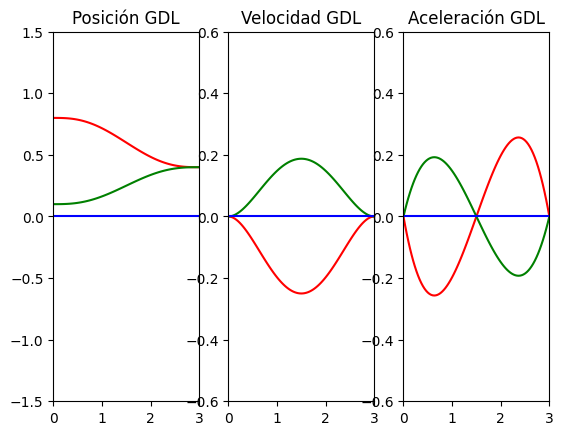

In [3]:
#Calculando todos los valores por cinemàtica inversa
for a in range(samples - 1):
  #Posiciòn
  ws.append((ws[a][0] + ws_dot[a][0] * dt,
             ws[a][1] + ws_dot[a][1] * dt,
             ws[a][2] + ws_dot[a][2] * dt))
  #Velocidad
  q_dot_iter = q_O_P_dot.subs({
  x_O_P_dot:      gdl_dot[a+1][0],
  z_O_P_dot:      gdl_dot[a+1][1],
  theta_O_P_dot:  gdl_dot[a+1][2],
  theta_O_1:      ws[a+1][0],
  theta_1_2:      ws[a+1][1],
  theta_2_3:      ws[a+1][2]})
  ws_dot.append(q_dot_iter)
  #Aceleraciòn
  ws_dot_dot.append((
                    (ws_dot[a+1][0] - ws_dot[a][0]) / dt,
                    (ws_dot[a+1][1] - ws_dot[a][1]) / dt,
                    (ws_dot[a+1][2] - ws_dot[a][2]) / dt
                    ))
  print("Iteraciòn: "  + str(a))
#Aceleraciòn final
ws_dot_dot.append((0,0,0))
gdl = gdl
gdl_dot = gdl_dot
gdl_dot_dot = gdl_dot_dot
ws = ws
ws_dot = ws_dot
ws_dot_dot = ws_dot_dot

#Grados de libertad
gdl_t = []
gdl_p_0 = []
gdl_p_1 = []
gdl_p_2 = []
gdl_v_0 = []
gdl_v_1= []
gdl_v_2 = []
gdl_a_0 = []
gdl_a_1 = []
gdl_a_2 = []

for i in range(len(gdl)):
  gdl_t.append(float(i) / frec)
  gdl_p_0.append(gdl[i][0])
  gdl_p_1.append(gdl[i][1])
  gdl_p_2.append(gdl[i][2])
  gdl_v_0.append(gdl_dot[i][0])
  gdl_v_1.append(gdl_dot[i][1])
  gdl_v_2.append(gdl_dot[i][2])
  gdl_a_0.append(gdl_dot_dot[i][0])
  gdl_a_1.append(gdl_dot_dot[i][1])
  gdl_a_2.append(gdl_dot_dot[i][2])

fig, ((gdl_plot, gdl_dot_plot, gdl_dot_dot_plot)) = plt.subplots(nrows = 1, ncols = 3)  

#Gráficas GDL
gdl_plot.set_title("Posición GDL")
gdl_plot.axis((0, 3, -1.5, 1.5))
gdl_plot.plot(gdl_t, gdl_p_0, color = "RED")
gdl_plot.plot(gdl_t, gdl_p_1, color = "GREEN")
gdl_plot.plot(gdl_t, gdl_p_2, color = "BLUE")
gdl_dot_plot.set_title("Velocidad GDL")
gdl_dot_plot.axis((0, 3, -0.6, 0.6))
gdl_dot_plot.plot(gdl_t, gdl_v_0, color = "RED")
gdl_dot_plot.plot(gdl_t, gdl_v_1, color = "GREEN")
gdl_dot_plot.plot(gdl_t, gdl_v_2, color = "BLUE")
gdl_dot_dot_plot.set_title("Aceleración GDL")
gdl_dot_dot_plot.axis((0, 3, -0.6, 0.6))
gdl_dot_dot_plot.plot(gdl_t, gdl_a_0, color = "RED")
gdl_dot_dot_plot.plot(gdl_t, gdl_a_1, color = "GREEN")
gdl_dot_dot_plot.plot(gdl_t, gdl_a_2, color = "BLUE")

plt.show()

### 4. Aplicación de la cinemática inversa
Finalmente, a partir de los puntos de la trayectoria y el modelo de cinemática inversa, obtener las posiciones, velocidades y aceleraciones de las juntas del robot, así como sus gráficas en función del tiempo

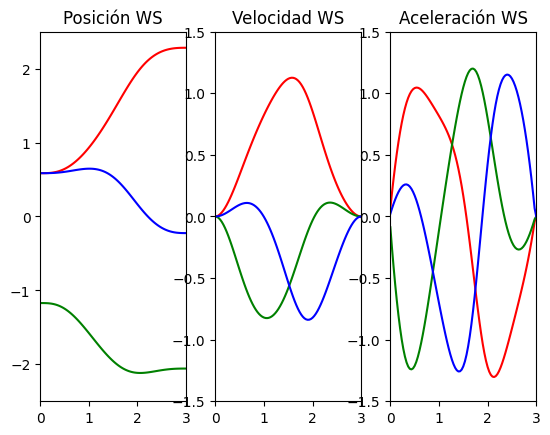

In [4]:
#Espacio de trabajo
ws_t = []
ws_p_0 = []
ws_p_1 = []
ws_p_2 = []
ws_v_0 = []
ws_v_1= []
ws_v_2 = []
ws_a_0 = []
ws_a_1 = []
ws_a_2 = []

for i in range(len(ws)):
  ws_t.append(float(i) / frec)
  ws_p_0.append(ws[i][0])
  ws_p_1.append(ws[i][1])
  ws_p_2.append(ws[i][2])
  ws_v_0.append(ws_dot[i][0])
  ws_v_1.append(ws_dot[i][1])
  ws_v_2.append(ws_dot[i][2])
  ws_a_0.append(ws_dot_dot[i][0])
  ws_a_1.append(ws_dot_dot[i][1])
  ws_a_2.append(ws_dot_dot[i][2])
    
fig, ((ws_plot, ws_dot_plot, ws_dot_dot_plot)) = plt.subplots(nrows = 1, ncols = 3)  


#Gráficas WS
ws_plot.set_title("Posición WS")
ws_plot.axis((0, 3, -2.5, 2.5))
ws_plot.plot(ws_t, ws_p_0, color = "RED")
ws_plot.plot(ws_t, ws_p_1, color = "GREEN")
ws_plot.plot(ws_t, ws_p_2, color = "BLUE")

ws_dot_plot.set_title("Velocidad WS")
ws_dot_plot.axis((0, 3, -1.5, 1.5))
ws_dot_plot.plot(ws_t, ws_v_0, color = "RED")
ws_dot_plot.plot(ws_t, ws_v_1, color = "GREEN")
ws_dot_plot.plot(ws_t, ws_v_2, color = "BLUE")
ws_dot_dot_plot.set_title("Aceleración WS")
ws_dot_dot_plot.axis((0, 3, -1.5, 1.5))
ws_dot_dot_plot.plot(ws_t, ws_a_0, color = "RED")
ws_dot_dot_plot.plot(ws_t, ws_a_1, color = "GREEN")
ws_dot_dot_plot.plot(ws_t, ws_a_2, color = "BLUE")
plt.show()

### 5. Github
Para terminar, crear un repositorio en línea en gihub, donde se subirán los archivos de la práctica. 
Se recomienda primero crear el repositorio en línea, clonarlo en el ordenador y después incluir los archivos de la práctica. 
Para utilizar el repositorio para todas las prácticas posteriores, se recomienda usar la siguiente estructura de archivos:
~~~ bash
repositorio_practicas/
├── practica_2
│   ├── imagenes
│   │   └── P2_IM1.png
│   └── Practica_2.ipynb
└── README.md
~~~
Dentro del archivo README.md (Creado de forma automática en el repositorio en línea), colocar los nombres de los integrantes del equipo.

## Análisis de resultados

¿Qué utilidad tiene el modelo de cinemática inversa de un robot?
> Nos permite conocer los valores de las variables que describen el movimiento de las juntas a partir de una posición final deseada del efector final.

¿Controlar las condiciones iniciales y finales de la trayectoria del efector final tiene un efecto en las condiciones inicial y final de las juntas?
> Sí, las condiciones iniciales y finales de la trayectoria del efector final afectan directamente a las condiciones iniciales y finales de las juntas. Se puede ver en la gráfica de posición de las juntas del robot (actividad 4), las tres variables inician y terminan en un valor diferente.

¿Qué utilidad tiene el uso de un repositorio en línea para código?
> Un repositorio en línea es útil para respaldo, acceso remoto, colaboración de múltiples programadores y control de versiones.




## Conclusiones

Se cumplieron las metas de la práctica, se calculó la trayectoria de un mecanismo sencillo de 4 barras a partir de la posición inicial y final del efector final. Posteriormente, se graficaron los resultados obtenidos, los valores de posición, velocidad y aceleración del efector final y de las juntas del robot. Por último, subimos nuestra práctica a un repositorio en github y le hicimos modificaciones remotamente.

## Bibliografía 

 - *Acerca de GitHub y Git - documentación de GitHub.* (s. f.). GitHub Docs. https://docs.github.com/es/get-started/start-your-journey/about-github-and-git

